# Карты Рамачандрана для соединений из базы PDB

In [1]:
import warnings

%load_ext autoreload
%autoreload 2

from torsion import fetch_pdb, load_pdb
from torsion import phi_psi_angles, ram_plot

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

In [2]:
def ram_from_pdb_id(pdb_id, **kwargs):
    "helper function to plot RAM for given PDB ID"
    pdb_struct = fetch_pdb(pdb_id)
    ram_plot(*phi_psi_angles(pdb_struct), pdb_id, **kwargs)
    
    
def ram_from_pdb_file(pdb_file, pdb_id, **kwargs):
    "helper function to plot RAM from .cif file"
    pdb_struct = load_pdb(pdb_file)
    ram_plot(*phi_psi_angles(pdb_struct), pdb_id, **kwargs)

# Задание

В тестовом задании мне было необходимо отрисовать карты Рамачандрана для трех любых соединения из базы PDB. После некоторого гугления, я решил, что это не так сложно, поэтому можно не использовать готовое, а написать небольшой модуль для отрисовки графиков из .cif (.pdb кажется устарел) файлов или просто по ID. Заодно разобраться зачем эти карты нужны и побольше узнать. 

**Небольшое саммари**:
- С помощью модуля можно: 
    - получить торсионные углы (я не считал их сам, думаю это излишне, а использовал biopython, так больше совместимость)
    - загружать/скачивать .cif файлы. Все это возвращается в виде обьектов из biopython, поэтому со структурой можно работать как "обычно". 
    - строить карты.

- На графиках можно отобразить плотность, вторичную структуру (а-спирали/б-листы и еще чуть), контуры (правда не совсем те, что нужно)

Прежде, я кратко изложу что узнал, возможно я понял что-то не так и был бы рад услышать фидбек. ~~надо было не спать на уроках органической химии когда-то~~

# Торсионные углы

Для того, чтобы однозначно описать структуру молекулы, нам недостаточно просто знать ее формулу (набор атомов/соединения). Может так получится, что два соединения имеют одинаковые формулы, но тем не менее различны. За это отвечают *конфигурация* и *конформация*.

**Конфигурация** - набор атомов и порядок их соединения.

**Конформация** - расположение атомов в пространстве.

![](figs/conf.png)

Конформацию можно описать двумя типами углов - валентными и торсионными.

**Валентный угол** определяется как угол между двумя связями примыкающими к одному атому, то есть он плоский. Тем не менее, только его также недостаточно, т.к атомы не всегда лежат в одной плоскости. 

![](figs/conf3d.png)

Поэтому, для однозначного определения конформации нужны **торсионные углы** - двугранные углы определяющие разворот молекул относительно какой-то связи. Угол может принимать значения от 180 до -180 градусов.

# Карта Рамачандрана

При описании конформации белков используют несколько (три точнее) торсионных углов, вокруг связей образующих главную цепь (C$\alpha$), углы обозначаются $\phi$ (вокруг $C\alpha-N$), $\psi$ (вокруг $C\alpha-C$), $\omega$ (чаще всего константа из-за того, как устроена пептидная связь).

Структуру же всего белка можно описать совокупоностью углов $\phi$ и $\psi$ для всех аминокислотных остатков. При нанисении их на график, получается карта Рамачандрана. Оси имеют значения от -180 до 180. Обычно добавляют области допустимых значений углов и недопустимых.

![как должно быть](figs/ideal_plot.png)

Подобные карты дают какое-то общее наглядное представление о структуре белка, однако полезны не только этим. С помощью них легко можно увидеть повторяющиеся паттерны, которые называются вторичной структурой белка. Их бывает достаточно много, но самые частые $\alpha$-спирали и $\beta$-листы. 

Интересно, что на некоторых областях графика почти никогда не встречаются наблюдения, это проверяли также и [импирически](https://www.ncbi.nlm.nih.gov/pubmed/8994966). Так происходит из-за того, что не все углы возможны, большинство конфигураций невозможно из-за столкновения атомов. 

Поэтому торсионные углы можно использовать в качестве оценки качества [(Lovell et al., 2003)](https://onlinelibrary.wiley.com/doi/abs/10.1002/prot.10286) ~~4к цитирований wow~~ моделей предсказывающих структуру белка. Если в предсказанной моделью структуре будет множество невозможных углов, то она вероятно неверна. Углы можно предсказывать и как таргет.

> Ramachandran plot is one of the simplest and most sensitive means for assessing the quality of a protein model in the absence of experimental data (Lovell et al., 2003)

Насколько я понимаю, судя по результатм на CASP13 SotA сейчас является [AlphaFold](https://www.nature.com/articles/s41586-019-1923-7) от deepmind, где они предсказывают расстояния между остатками. 

# Карты Рамачандрана для соединений из PDB

В моей имплементации не хватает контура для разных областей разрешенных/запрещенных углов. Честно говоря, так до конца и не понял как правильно его считать. В пейпере (Lovell et al., 2003) предлагают какую-то свою функцию для оценки плотности, в более старом же [(Kleywegt G., 1996)](https://www.ncbi.nlm.nih.gov/pubmed/8994966) просто разделили график на квадртаты 10x10 градусов и посчитали распределение по базе данных. Я решил keep it simple и не делать этого, добавил просто gaussian kde из scipy.

В целом для каждого соединения на графиках и правда видно (по плотности), какая из вторичных структур преобладает.

### Reduced (CuI) poplar plastocyanin: 6PCY

<img src="figs/6PCY.png" width="300"/>

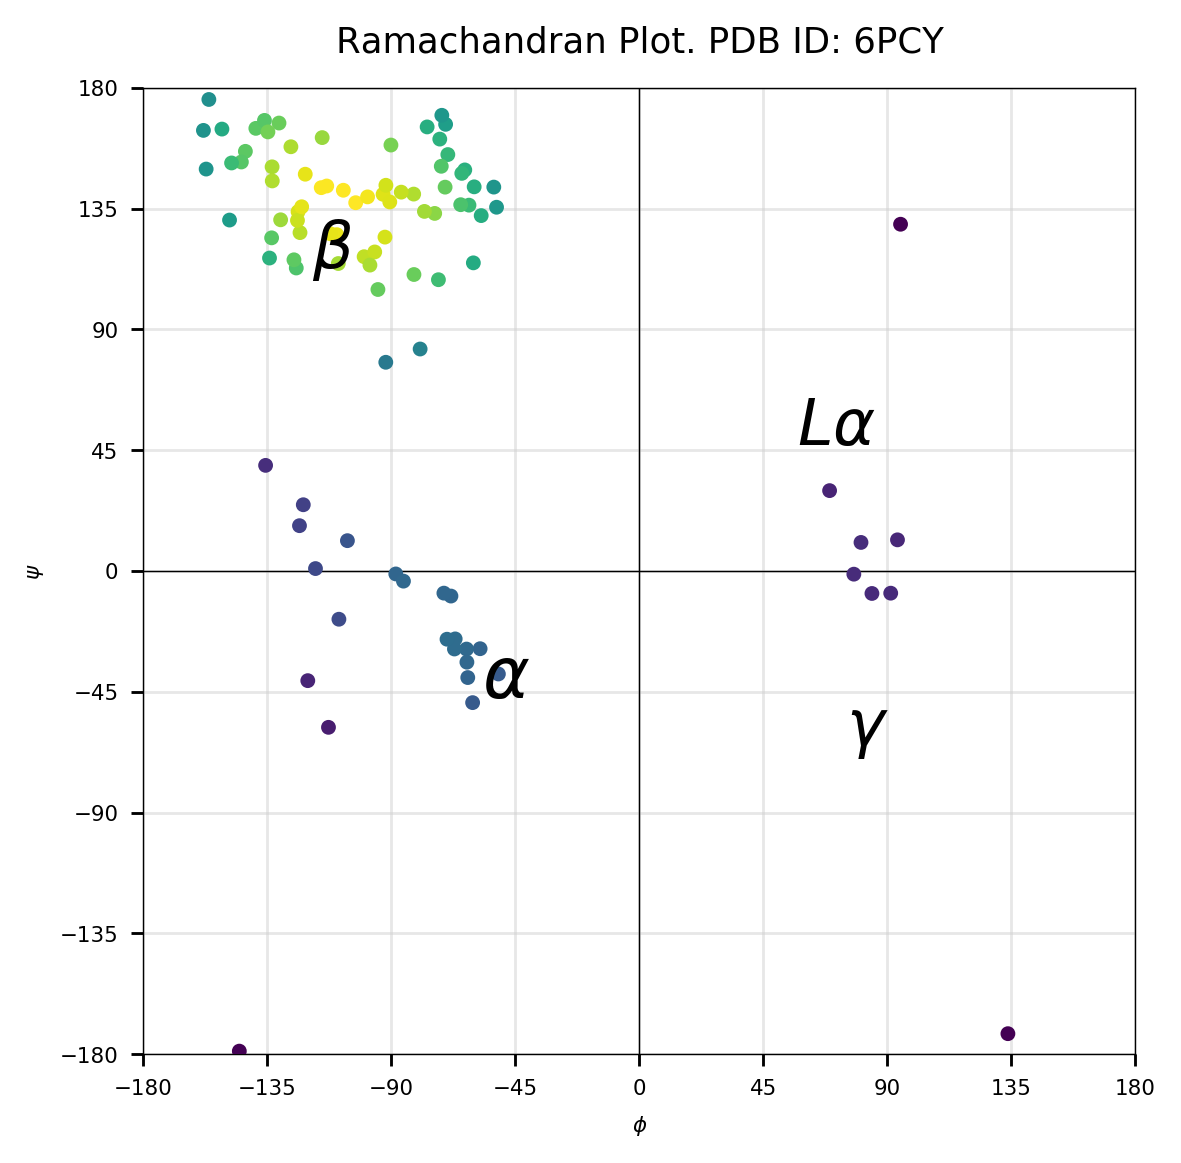

In [3]:
ram_from_pdb_id("6PCY", density=True, secondary=True)

### Human Prolidase: 2IW2

<img src="figs/2IW2.png" width="300"/>

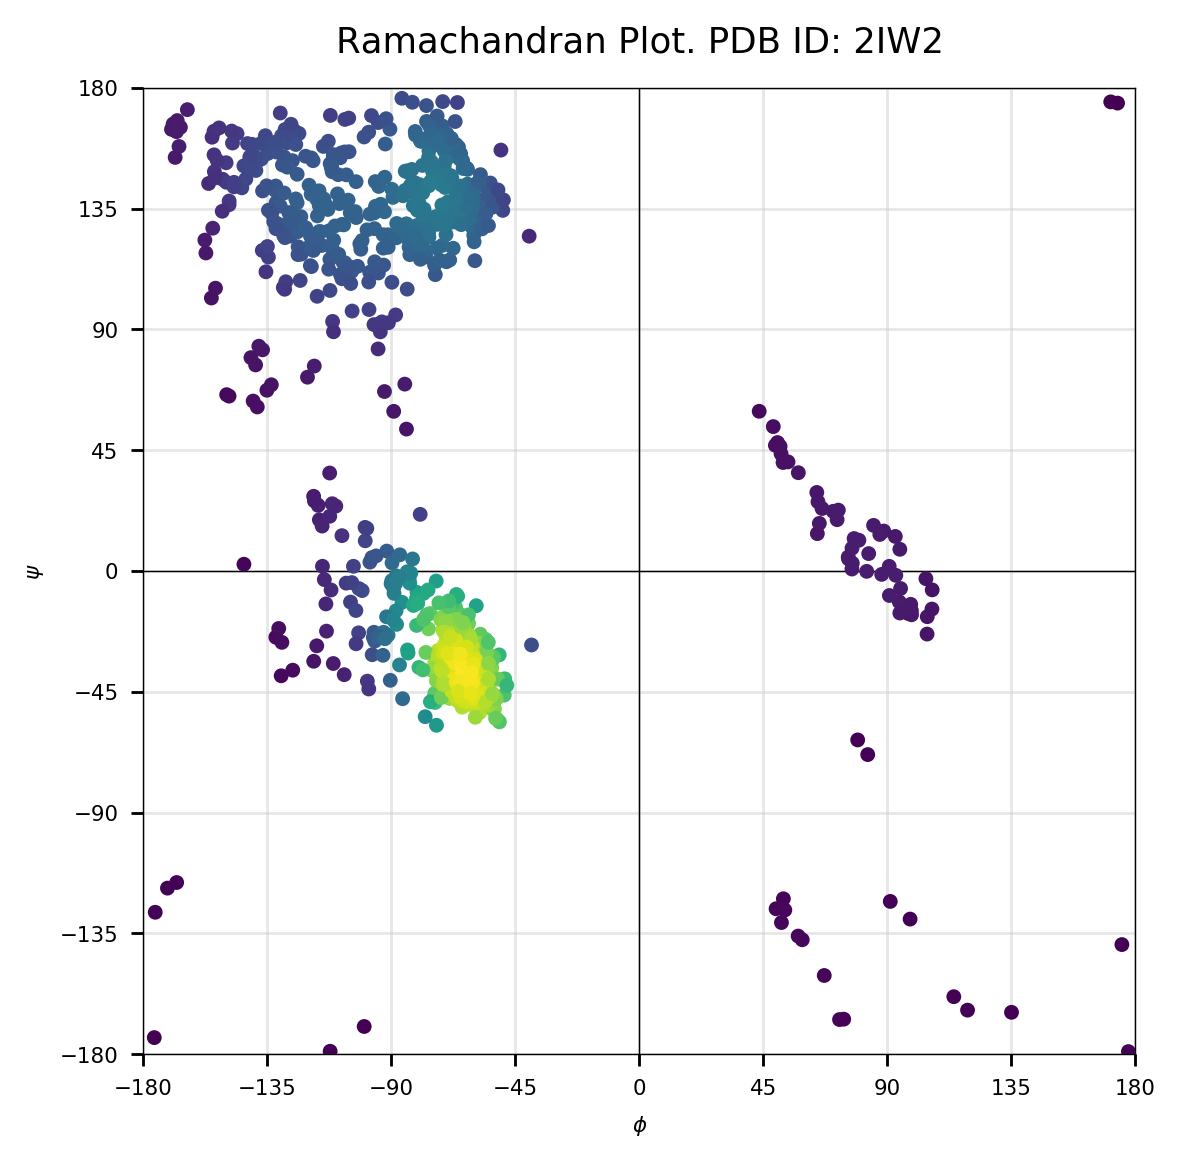

In [73]:
ram_from_pdb_id("2IW2", density=True)

### Immunoglobulin: 1IGT

<img src="figs/1IGT.png" width="300"/>

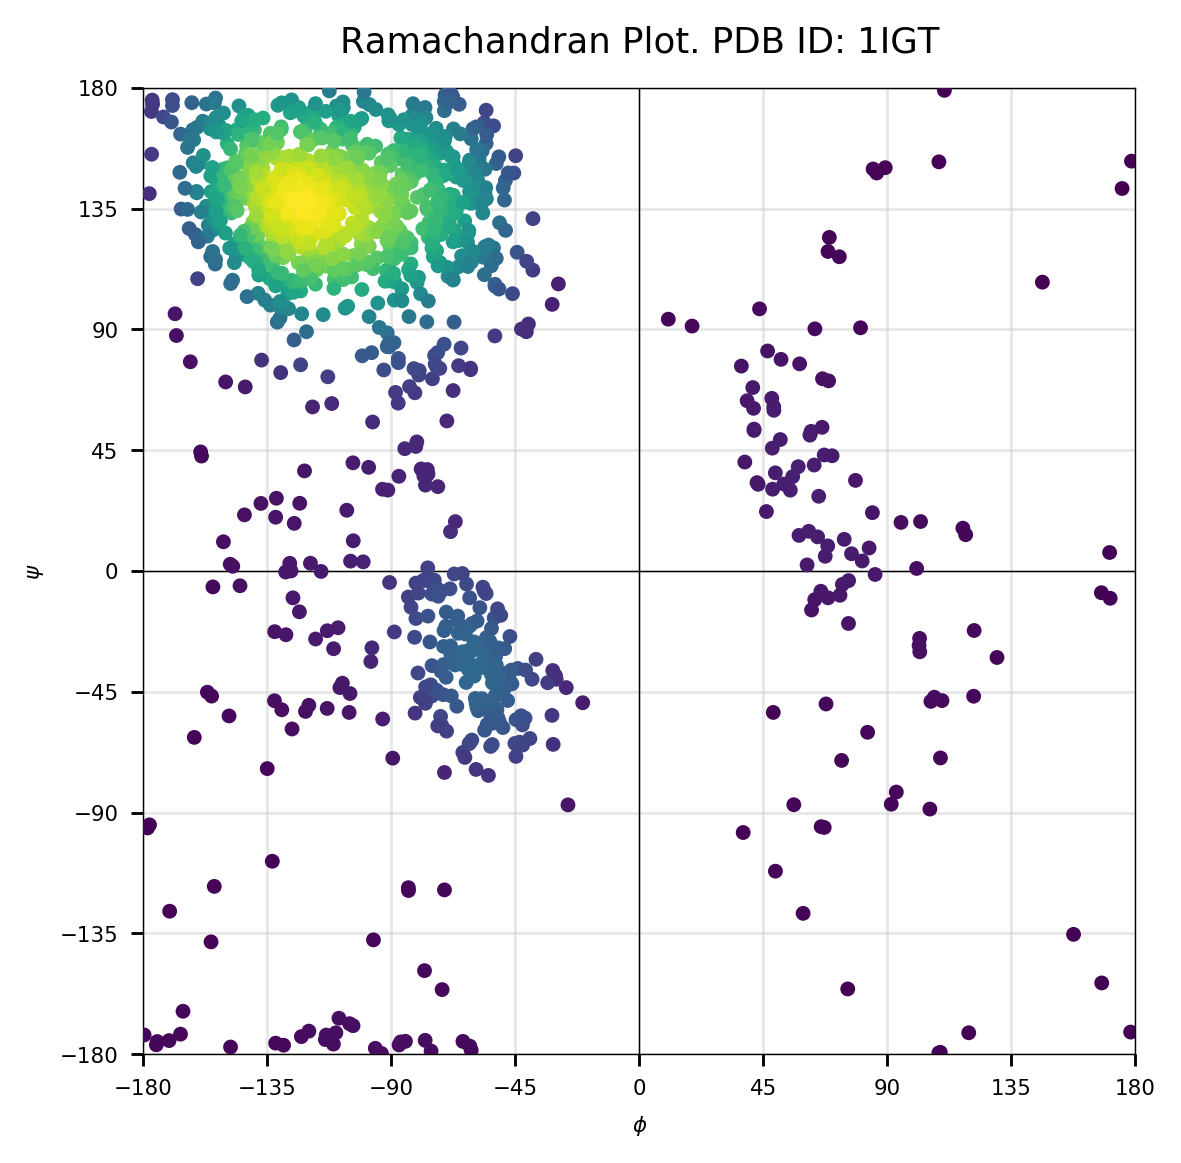

In [74]:
ram_from_pdb_id("1IGT", density=True)

# Additional

В такое время живем, а как без этого!

### Structure of novel coronavirus spike receptor-binding domain complexed with its receptor ACE2 (Angiotensin-converting enzyme 2): 6LZG 

<img src="figs/6LZG.png" width="300"/>

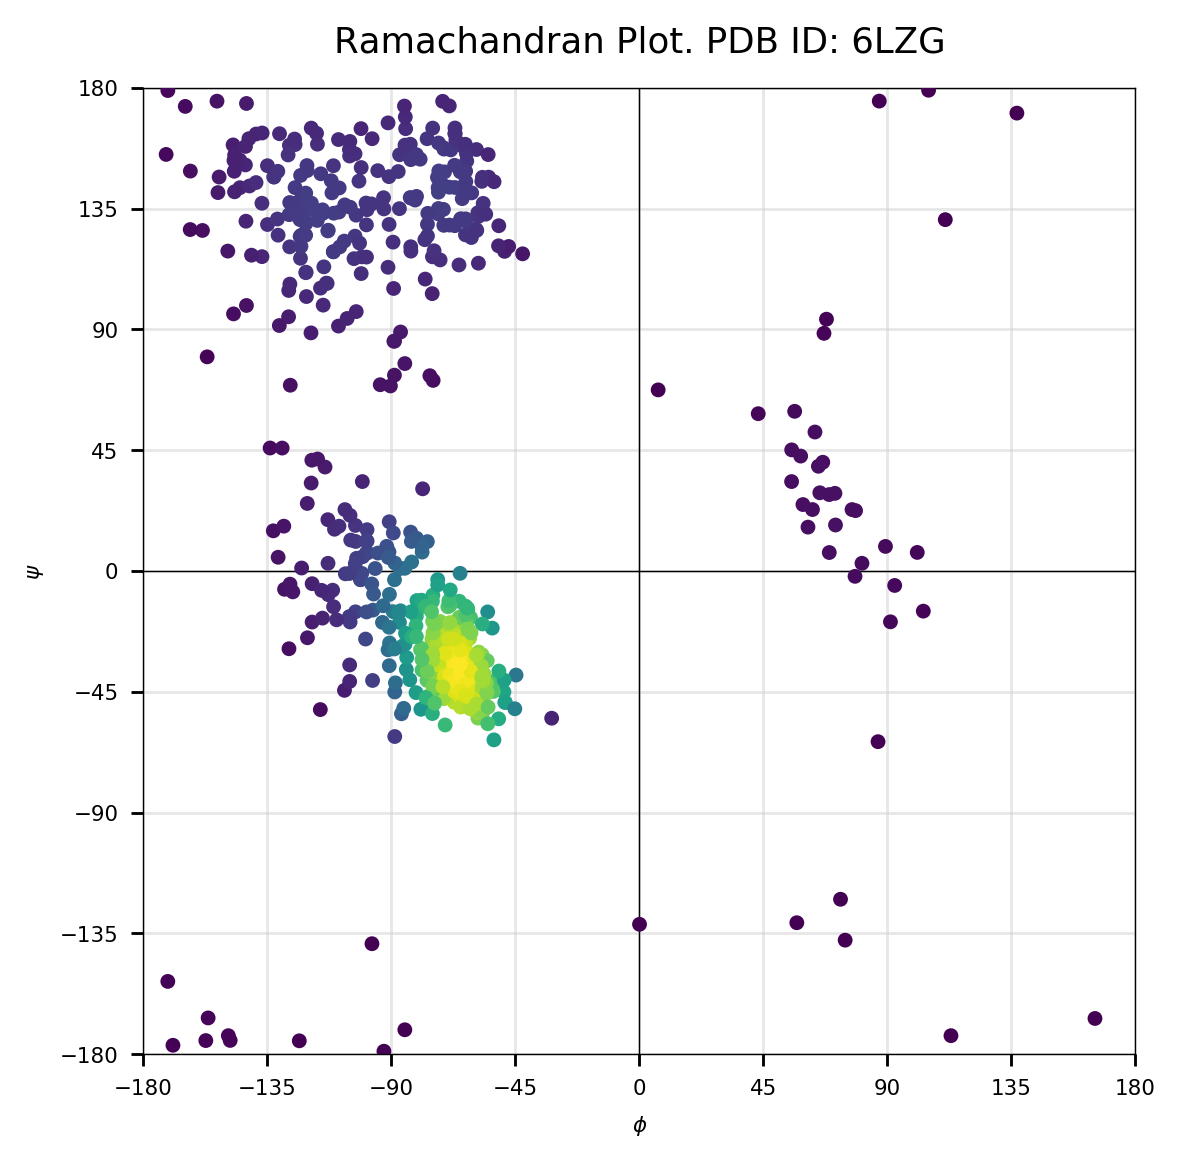

In [77]:
ram_from_pdb_id("6LZG", density=True)

# References

- [очень](https://xn--n1afeh.xn--80abvyzg.xn--p1ai/%D0%BC%D0%BE%D0%BB%D0%B5%D0%BA%D1%83%D0%BB%D1%8B/%D0%A0%D0%B0%D0%BC%D0%B0%D1%87%D0%B0%D0%BD%D0%B4%D1%80%D0%B0%D0%BD.html#lookL) понятное обьяснение того, что такое карты рамачандрана, с наглядной визуализацией, отсюда взял картинки
- хорошее [видео](https://www.youtube.com/watch?v=Q1ftYq13XKk), опять же с визуализацией, но здесь обьясняется про невозможные углы из-за столкновения атомов, и как вытекающее - вторичную струтуру спирали/листы
- [статья](https://proteinstructures.com/Structure/Structure/Ramachandran-plot.html) из задания, помогла понять зачем эти карты нужны
- [protein folding](https://www.youtube.com/watch?v=hok2hyED9go) - незнакомый для меня, но очень важный концепт судя по пейперам